In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import PIL
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_io")

2024-02-24 12:26:51.095596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 12:26:51.095747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 12:26:51.380118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Paths to the datasets directories
base_dir1 = '/kaggle/input/solar-panels-dirt-detection/Detect_solar_dust'
base_dir2 = '/kaggle/input/solar-panel-dust-detection/Detect_solar_dust'  # Add the path to your other dataset
classes = ['Clean', 'Dusty']

# Create directories for train, test, and validation if they don't exist
for dir_name in ['/kaggle/working/train', '/kaggle/working/test', '/kaggle/working/validate']:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [4]:
def process_class(class_name):
    # Ensure the directory for each class in train, test, validate exists
    for subdir in ['/train/', '/test/', '/validate/']:
        os.makedirs(f'/kaggle/working{subdir}{class_name}', exist_ok=True)

    # Combine files from both datasets
    files1 = os.listdir(os.path.join(base_dir1, class_name))
    files2 = os.listdir(os.path.join(base_dir2, class_name))
    files = [os.path.join(base_dir1, class_name, f) for f in files1] + [os.path.join(base_dir2, class_name, f) for f in files2]
    
    # Split files into training and (test + validate) sets
    train_files, test_validate_files = train_test_split(files, test_size=0.3, random_state=42)

    # Further split the (test + validate) set into test and validate sets
    test_files, validate_files = train_test_split(test_validate_files, test_size=(1/3), random_state=42)

    # Copy files to their respective directories
    for f in train_files:
        shutil.copy(f, f'/kaggle/working/train/{class_name}/')
    for f in test_files:
        shutil.copy(f, f'/kaggle/working/test/{class_name}/')
    for f in validate_files:
        shutil.copy(f, f'/kaggle/working/validate/{class_name}/')

# Process each class
for class_name in classes:
    process_class(class_name)

In [5]:
BATCH_SIZE = 48
image_height = 299
image_width = 299
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'                                   
)


In [8]:
# Train generator
test_val_data_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_data_generator.flow_from_directory(
    directory="/kaggle/working/train",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=1234
)

# Test generator
test_generator = test_val_data_generator.flow_from_directory(
    directory="/kaggle/working/test",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=1234
)

# Validation generator
validate_generator = test_val_data_generator.flow_from_directory(
    directory="/kaggle/working/validate",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=1234
)

Found 2390 images belonging to 2 classes.
Found 738 images belonging to 2 classes.
Found 369 images belonging to 2 classes.


In [9]:
# Get the mapping of class names to class indices
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))

# Extract the class names
class_names = list(dict_class.keys())
print('Class labels: {}'.format(class_names))

Dictionary: {'Clean': 0, 'Dusty': 1}
Class labels: ['Clean', 'Dusty']


In [10]:
# Print the dataset characteristics for the training set
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator.classes))
for class_name, class_index in train_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(train_generator.classes == class_index))

print()  # Add a newline for better readability

# Print the dataset characteristics for the test set
print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
for class_name, class_index in test_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(test_generator.classes == class_index))

print()  # Add a newline for better readability

# Print the dataset characteristics for the validation set
print("Dataset Characteristics of Validation Data Set:")
print("Number of images:", len(validate_generator.classes))
for class_name, class_index in validate_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(validate_generator.classes == class_index))

print()  # Add a newline for better readability

Dataset Characteristics of Train Data Set:
Number of images: 2390
Number of Clean images: 1411
Number of Dusty images: 979

Dataset Characteristics of Test Data Set:
Number of images: 738
Number of Clean images: 425
Number of Dusty images: 313

Dataset Characteristics of Validation Data Set:
Number of images: 369
Number of Clean images: 212
Number of Dusty images: 157



Train image data from Data Augmentation 1 *Preprocessing*


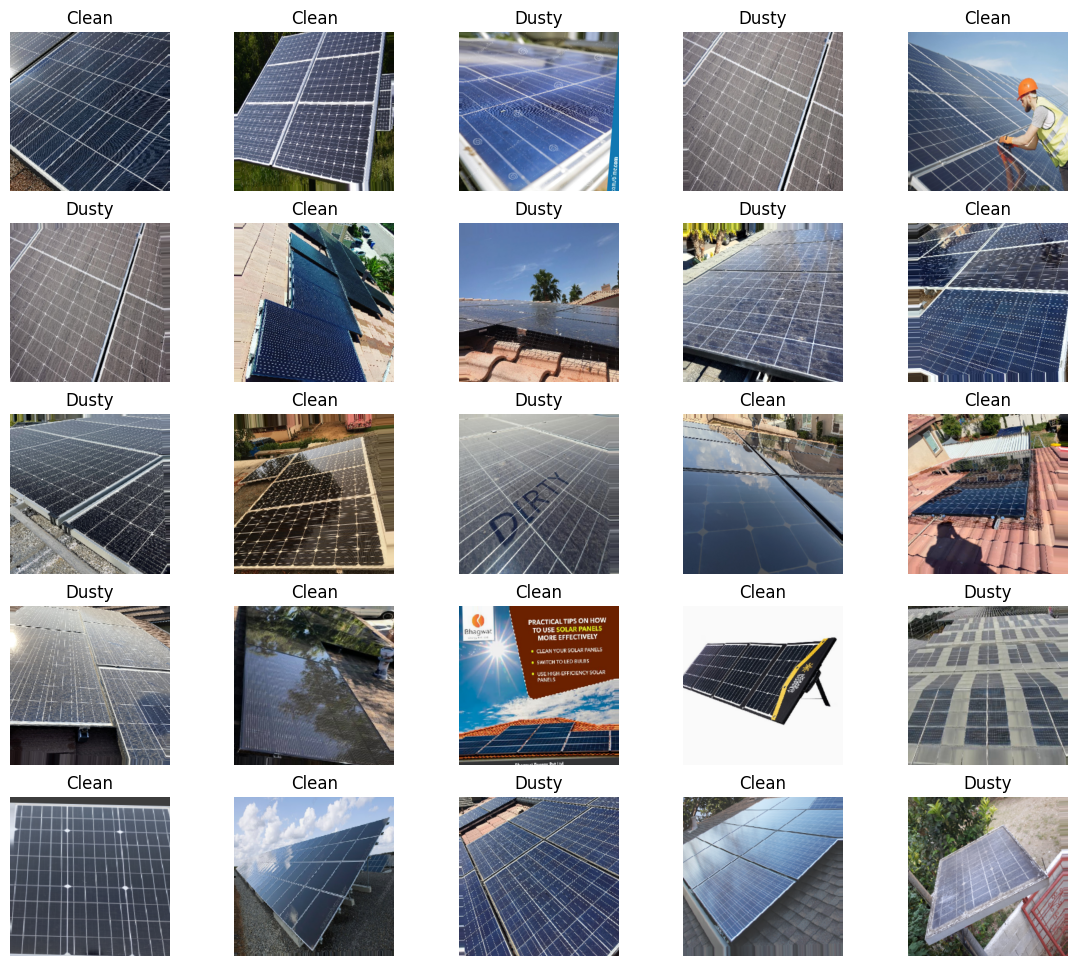

In [11]:
# Image Samples
print('Train image data from Data Augmentation 1 *Preprocessing*')
img, label = next(train_generator)

plt.figure(figsize=[14, 12])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

In [12]:
# Initialize VGG16 model with pre-trained weights on ImageNet,
# excluding the fully connected layers for feature extraction.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
base_model.trainable = False

In [14]:
# Add custom layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax')) 

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 256)               10617088  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 25332290 (96.64 MB)
Trainable params: 10617602 (40.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [16]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 0.8469170800850461, 1: 1.2206332992849847}

# Training the model 

In [21]:
epoch = 15
# Train the model using the training generator, validating on the validation generator,
# specifying the number of epochs, and incorporating class weights for imbalanced datasets.
history = model.fit(train_generator, validation_data=validate_generator, epochs=epoch, class_weight=class_weights)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1708778699.205320     205 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 147s 2s/step - loss: 1.0313 - accuracy: 0.6113 - val_loss: 0.5708 - val_accuracy: 0.6911
Epoch 2/15
50/50 [==============================] - 97s 2s/step - loss: 0.5797 - accuracy: 0.6975 - val_loss: 0.5884 - val_accuracy: 0.6748
Epoch 3/15
50/50 [==============================] - 96s 2s/step - loss: 0.5426 - accuracy: 0.7213 - val_loss: 0.5334 - val_accuracy: 0.7154
Epoch 4/15
50/50 [==============================] - 96s 2s/step - loss: 0.4902 - accuracy: 0.7682 - val_loss: 0.6341 - val_accuracy: 0.6531
Epoch 5/15
50/50 [==============================] - 96s 2s/step - loss: 0.5036 - accuracy: 0.7347 - val_loss: 0.5062 - val_accuracy: 0.7236
Epoch 6/15
50/50 [==============================] - 96s 2s/step - loss: 0.4879 - accuracy: 0.7360 - val_loss: 0.5101 - val_accuracy: 0.7371
Epoch 7/15
50/50 [==============================] - 98s 2s/step - loss: 0.4646 - accuracy: 0.7644 - val_loss: 0.5058 - val_accuracy: 0.7534
Epoch 8/15
50/50 [============

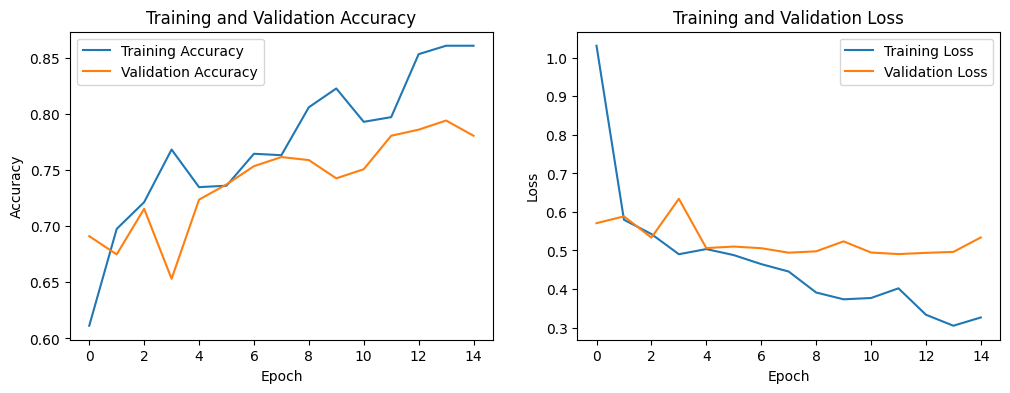

In [22]:
# Extract training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
# Evaluate the model on the test datawith class weights
evaluation = model.evaluate(test_generator)

# The evaluation result is a list containing the loss and any metrics you specified during model compilation
loss, accuracy = evaluation

print("Evaluation Results:")
print("Test Loss: {:.4f}".format(loss))
print("Test Accuracy: {:.2%}".format(accuracy))

16/16 [==============================] - 25s 2s/step - loss: 0.4457 - accuracy: 0.8198
Evaluation Results:
Test Loss: 0.4457
Test Accuracy: 81.98%


In [24]:
# Obtain true labels and predictions during testing
true_labels = []
predictions = []

# Reset the test generator to the beginning
test_generator.reset()

# Loop through the test generator to accumulate true labels and predictions
for i in range(len(test_generator)):
    images, labels = next(test_generator)
    true_labels.extend(labels)
    predictions_batch = model.predict(images)
    predictions.extend(predictions_batch)

# Convert lists to NumPy arrays
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

1/1 [==============================] - 0s 29ms/step


2/2 [==============================] - 0s 239ms/step


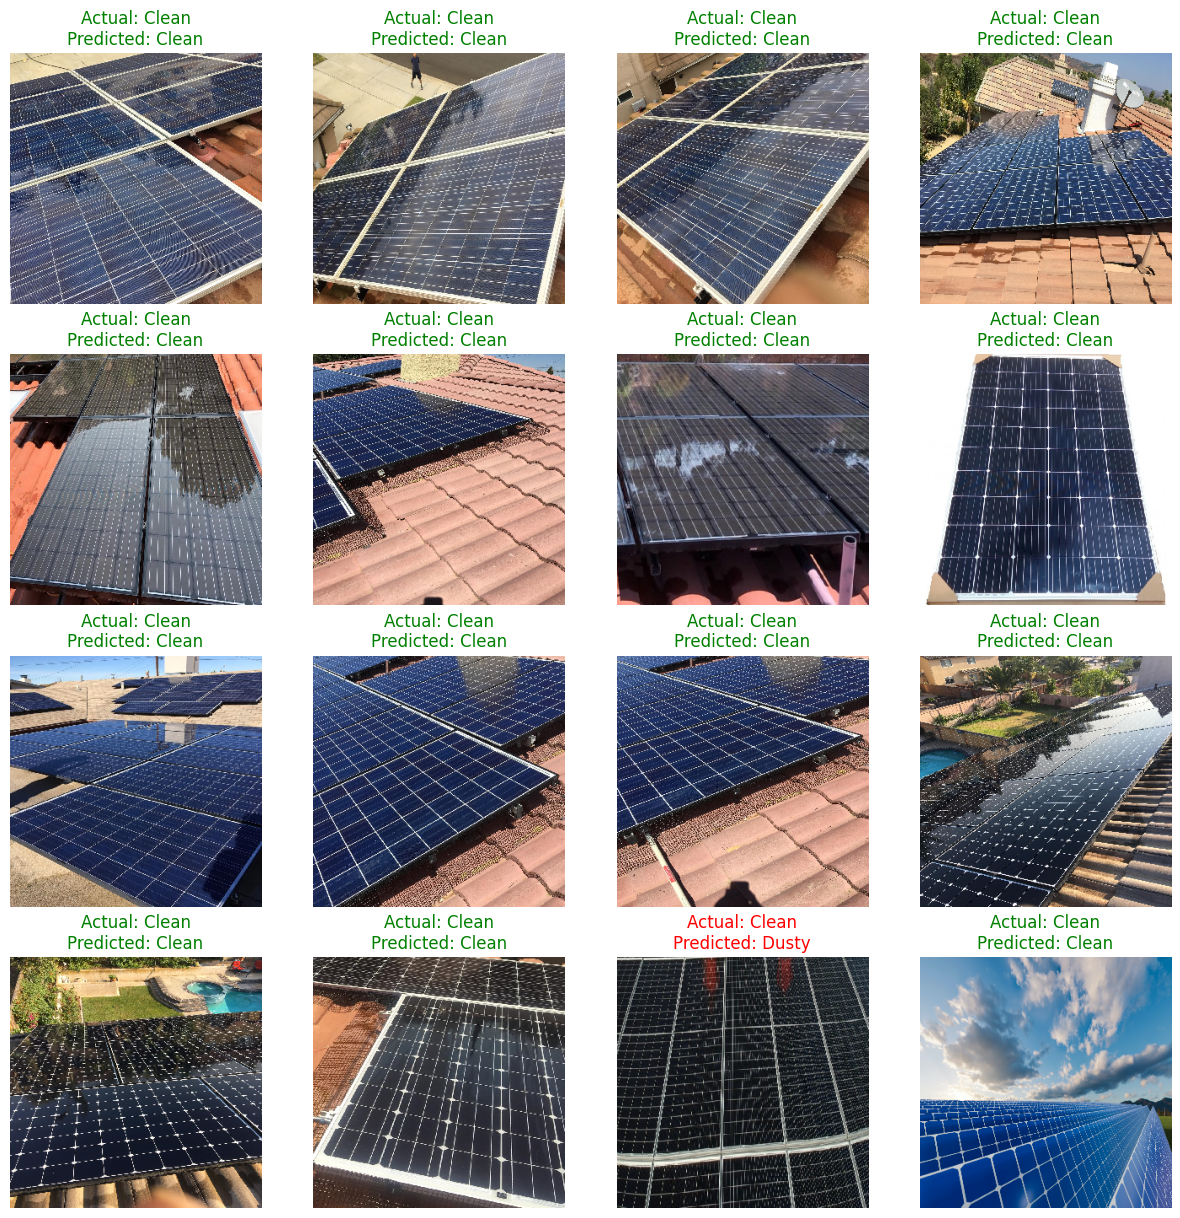

In [25]:
# Visualize a sample of images with true and predicted labels
num_samples = 16  # Change this based on how many samples you want to visualize

# Reset the test generator to the beginning
test_generator.reset()

# Obtain a batch of images and labels from the test generator
images, true_labels = next(test_generator)

# Predictions for the batch
predictions_batch = model.predict(images)

# Convert the batch predictions and true labels to NumPy arrays
predictions = np.argmax(predictions_batch, axis=1)
true_labels = np.argmax(true_labels, axis=1)

# Rescale pixel values to the range [0, 255]
images = (images * 255).astype("uint8")

# Visualize a sample of images with true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(min(num_samples, len(true_labels))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]) 
     
    if class_names[true_labels[i]] == class_names[predictions[i]]:
        title_color = 'green'
    else:
        title_color = 'red'
    
    plt.title("Actual: {}\nPredicted: {}".format(class_names[true_labels[i]], class_names[predictions[i]]), color=title_color)
    plt.axis("off")

plt.show()

In [27]:
model.save('my_trained_vgg16_model.keras')

In [ ]:
``